In [2]:
import re
import os
import json
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
model_name = 'en_dense_lm_1_3b'
pattern = r'(\w+)_per_layer_(0|1)_k_(32)_seed_(\d+)_perm_(\d+)_lr_([\d\.]+)_bsz_(1)_clip_norm_(0)'
metric_cols = ['SimAOU', 'Random SimAOU', 'ICL-FTZS SimAM']
good_metric_cols = ['SimAOU', 'ICL-FTZS SimAM']
filenames = set(glob(f'../artifacts/results/{model_name}/*.json'))
# keep only those that match the pattern
filenames = [fn for fn in filenames if re.match(pattern, fn.split('/')[-1])]

### Analysis

In [4]:
data = []
for filename in filenames:
    # extract parameters from the filename using regex
    matches = re.findall(pattern, filename.split('/')[-1])
    task_name, per_layer, k, seed, perm, lr, bsz, clip_norm = matches[0]
    with open(filename, 'r') as fp:
        cur_data = json.load(fp)
    cur_data.update({'task': task_name, 
                     'method': ('Causal GD' if per_layer == '1' else 'GD'), 'k': k, 
                     'seed': seed, 'perm': perm, 'lr': lr, 'bsz': bsz, 
                     'clip_norm': clip_norm})
    data.append(cur_data)
data = pd.DataFrame.from_records(data)

#### Task Analysis

In [30]:
agg_table = (data.groupby(['task', 'method', 'seed'])[metric_cols]
 .agg(list).applymap(lambda x: np.mean(x, axis=1).squeeze()))

In [31]:
agg_table.groupby(['task', 'method']).agg(['mean', 'std']).round(3)

SimAOU        Random SimAOU        ICL-FTZS SimAM       
                   mean    std          mean    std           mean    std
task   method                                                            
agnews Causal GD  0.327  0.007         0.001  0.001          0.432  0.015
       GD         0.308  0.039         0.001  0.001          0.505  0.052
cb     Causal GD  0.344  0.003         0.004  0.000          0.382  0.010
       GD         0.205  0.008         0.004  0.001          0.246  0.010
mr     Causal GD  0.328  0.007         0.001  0.000          0.263  0.005
       GD         0.216  0.009         0.001  0.000          0.139  0.053
sst2   Causal GD  0.223  0.010         0.002  0.000          0.299  0.018
       GD         0.111  0.002         0.002  0.000          0.150  0.021
sst5   Causal GD  0.107  0.005         0.002  0.000          0.326  0.006
       GD         0.092  0.013         0.002  0.000          0.308  0.018
subj   Causal GD  0.345  0.007         0.002  0.000          0.322  0.006
       GD         0.177  0.018         0.002  0.000          0.254  0.066

#### Layerwise Analysis

In [7]:
# explode the list columns into separate columns
layer_table = pd.concat([
    data.set_index(['task', 'method', 'seed'])[col]
    .apply(lambda x: pd.Series(x).rename_axis(index='layer'))
    .stack() 
    for col in metric_cols
    ], keys=metric_cols, axis=1).drop(columns='Random SimAOU')

In [8]:
layer_table.groupby(['layer', 'method']).mean().round(3)

SimAOU  ICL-FTZS SimAM
layer method                           
0     Causal GD   0.503           0.019
      GD          0.166          -0.006
1     Causal GD  -0.077           0.213
      GD          0.012          -0.211
2     Causal GD   0.239           0.291
      GD          0.110          -0.043
3     Causal GD   0.103           0.522
      GD          0.165           0.048
4     Causal GD   0.318           0.580
      GD          0.193           0.088
5     Causal GD   0.250           0.610
      GD          0.072           0.293
6     Causal GD   0.341           0.575
      GD          0.221           0.211
7     Causal GD   0.220           0.451
      GD          0.203           0.220
8     Causal GD   0.288           0.464
      GD          0.155           0.284
9     Causal GD   0.286           0.228
      GD          0.201           0.339
10    Causal GD   0.313           0.354
      GD          0.213           0.316
11    Causal GD   0.285           0.512
      GD          0.245           0.358
12    Causal GD   0.346           0.381
      GD          0.273           0.466
13    Causal GD   0.307           0.407
      GD          0.297           0.600
14    Causal GD   0.311           0.384
      GD          0.298           0.602
15    Causal GD   0.323           0.250
      GD          0.257           0.492
16    Causal GD   0.270           0.412
      GD          0.239           0.613
17    Causal GD   0.362           0.510
      GD          0.157           0.693
18    Causal GD   0.360           0.500
      GD          0.204           0.483
19    Causal GD   0.457           0.438
      GD          0.069           0.357
20    Causal GD   0.235           0.189
      GD          0.196           0.128
21    Causal GD   0.254          -0.039
      GD          0.099          -0.003
22    Causal GD   0.199          -0.152
      GD          0.095          -0.003
23    Causal GD   0.210          -0.004
      GD          0.294           0.078

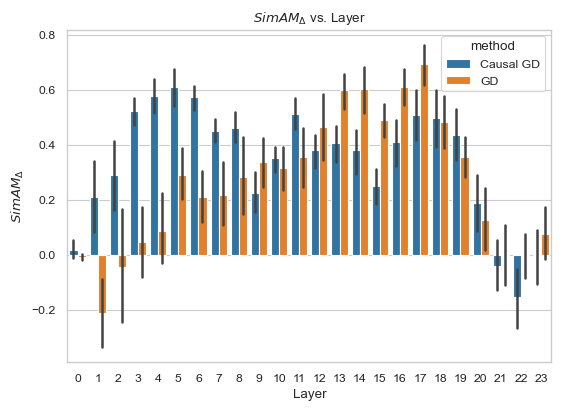

In [20]:
# plot layer_table as bar plot
sns.set_style('whitegrid')
sns.set_context('paper')
# create subplot per each metric
fig, ax = plt.subplots(figsize=(5.7, 4.2))
# metric_plot_name, metric_file_name, metric_data_col = 'SimAOU', 'simaou', 'SimAOU'
metric_plot_name, metric_file_name, metric_data_col = '$SimAM_\Delta$', 'simam', 'ICL-FTZS SimAM'
sns.barplot(data=layer_table, x='layer', y=metric_data_col, hue='method', ax=ax)
ax.set_xlabel('Layer')
ax.set_ylabel(metric_plot_name)
ax.set_title(f'{metric_plot_name} vs. Layer')
plt.tight_layout()
os.makedirs('../artifacts/figures', exist_ok=True)
plt.savefig(f'../artifacts/figures/{metric_file_name}_vs_layer.pdf', dpi=300)